In [ ]:
from google.colab import drive
import os
import glob
import zipfile

# 1. Mount Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 2. CONFIGURATION
# Path to your ZIP file on Drive
ZIP_PATH = "/content/drive/MyDrive/AML/WFDBRecords.zip"
# Where to extract files in Colab (faster IO than Drive)
EXTRACT_PATH = "/content/ecg_data"

def setup_environment():
    print(f"\n--- Setting up Environment ---")

    # Step A: Check if ZIP exists
    if not os.path.exists(ZIP_PATH):
        print(f" Error: ZIP file not found at: {ZIP_PATH}")
        return None

    # Step B: Unzip (only if not already done)
    if not os.path.exists(EXTRACT_PATH):
        print(f" Unzipping {ZIP_PATH} to {EXTRACT_PATH}...")
        print("   (This may take 2-5 minutes for 45k files...)")
        try:
            with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_PATH)
            print(" Unzip complete!")
        except zipfile.BadZipFile:
            print("Error: The file is not a valid ZIP file.")
            return None
    else:
        print(f" Data already extracted at {EXTRACT_PATH}")

    # Step C: Verify Files
    print("\n--- Verifying Data ---")
    mat_files = glob.glob(os.path.join(EXTRACT_PATH, "**", "*.mat"), recursive=True)
    hea_files = glob.glob(os.path.join(EXTRACT_PATH, "**", "*.hea"), recursive=True)

    print(f" Found {len(mat_files)} .mat files")
    print(f" Found {len(hea_files)} .hea files")

    if len(mat_files) > 0:
        print(f"\nExample file: {mat_files[0]}")
        return EXTRACT_PATH
    else:
        print(" Warning: No files found after unzipping.")
        return None

# Run Setup
data_root = setup_environment()

if data_root:
    print(f"\n SUCCESS! Update your pipeline config to use: data_root='{data_root}'")

Mounting Google Drive...
Mounted at /content/drive

--- Setting up Environment ---
 Unzipping /content/drive/MyDrive/AML/WFDBRecords.zip to /content/ecg_data...
   (This may take 2-5 minutes for 45k files...)
 Unzip complete!

--- Verifying Data ---
 Found 45152 .mat files
 Found 45152 .hea files

Example file: /content/ecg_data/WFDBRecords/42/427/JS42162.mat

 SUCCESS! Update your pipeline config to use: data_root='/content/ecg_data'



Training on: cuda

--- 1. SCANNING DATA ---
Parsing 45152 headers...


100%|██████████| 45152/45152 [00:09<00:00, 4838.55it/s]



[INFO] 'patient_diagnosis_status.csv' created successfully.
Dataset: 36460 samples, 5 classes.

--- STARTING 5-CLASS TRAINING ---
Epoch 1/35 | Val Acc: 83.0% | Loss: 0.3982
Epoch 2/35 | Val Acc: 89.9% | Loss: 0.3598
Epoch 3/35 | Val Acc: 81.8% | Loss: 0.3599
Epoch 4/35 | Val Acc: 85.5% | Loss: 0.3949
Epoch 5/35 | Val Acc: 91.6% | Loss: 0.3287
Epoch 6/35 | Val Acc: 91.8% | Loss: 0.3574
Epoch 7/35 | Val Acc: 89.8% | Loss: 0.3497
Epoch 8/35 | Val Acc: 86.1% | Loss: 0.3612
Epoch 9/35 | Val Acc: 90.0% | Loss: 0.3498
Epoch 10/35 | Val Acc: 88.1% | Loss: 0.3367
Epoch 11/35 | Val Acc: 86.3% | Loss: 0.3252
Epoch 12/35 | Val Acc: 88.0% | Loss: 0.3302
Epoch 13/35 | Val Acc: 89.5% | Loss: 0.3520
Epoch 14/35 | Val Acc: 90.6% | Loss: 0.3359
Epoch 15/35 | Val Acc: 90.7% | Loss: 0.3408
Epoch 16/35 | Val Acc: 88.6% | Loss: 0.3546
Epoch 17/35 | Val Acc: 88.6% | Loss: 0.3614
Epoch 18/35 | Val Acc: 89.4% | Loss: 0.4001
Epoch 19/35 | Val Acc: 89.0% | Loss: 0.4148
Epoch 20/35 | Val Acc: 90.5% | Loss: 0.468

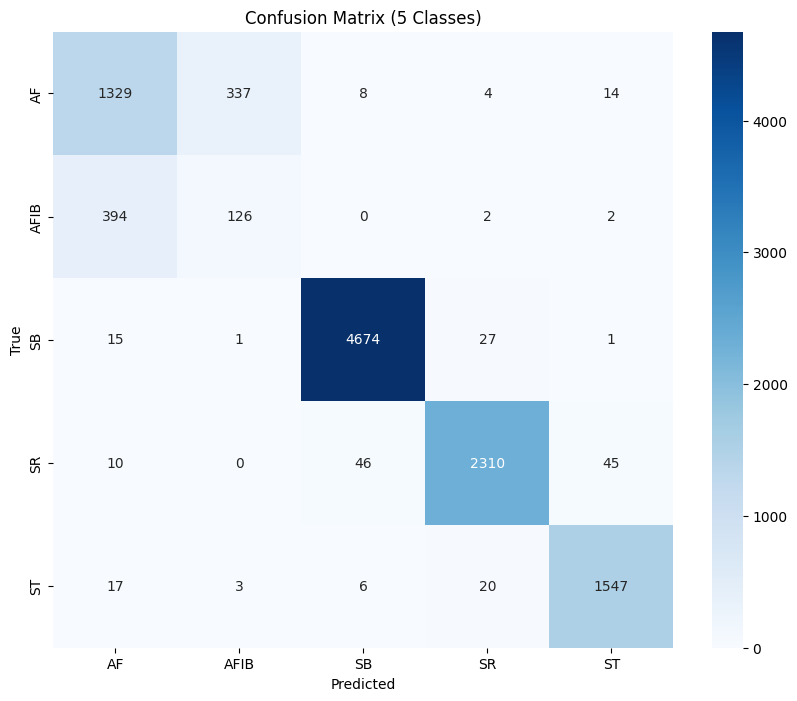

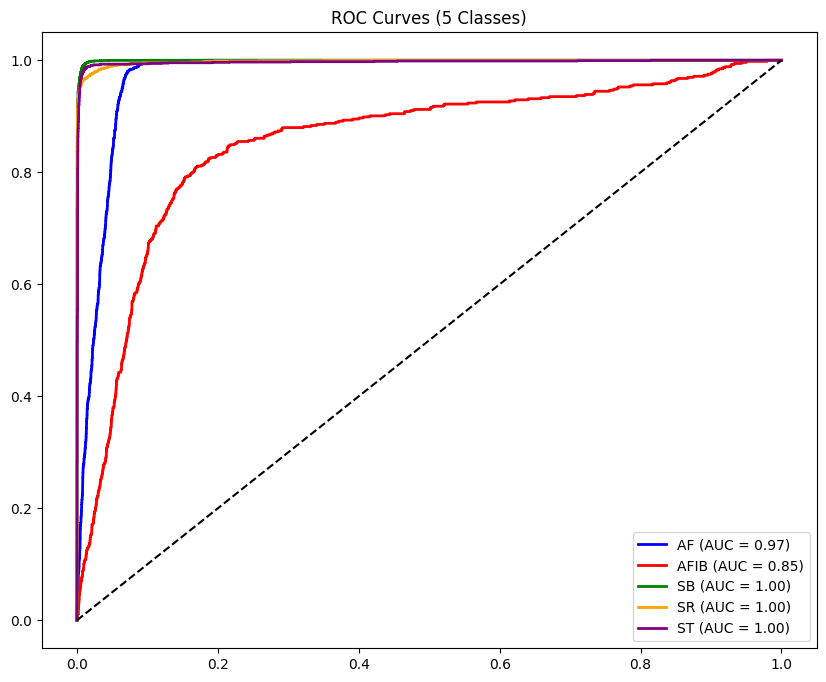

Done!


In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import scipy.io
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# 1. Configuration
CONFIG = {
    "batch_size": 64,
    "epochs": 35,              # More epochs for complex model
    "learning_rate": 0.0003,   # Lower LR for stability
    "min_samples": 50,
    "train_split": 0.7,
    "data_path": "/content/ecg_data/WFDBRecords",
    "conditions_file": "/content/ConditionNames_SNOMED-CT.csv",
    "target_diseases": [
        426177001, # Sinus Bradycardia (SB)
        426783006, # Sinus Rhythm (SR)
        164890007, # Atrial Flutter (AFL)
        427084000, # Sinus Tachycardia (ST)
        164889003  # Atrial Fibrillation (AFIB)
    ]
}

# 2. DATA HELPER
def read_ecg_file(file_path):
    try:
        data = scipy.io.loadmat(file_path)
        if 'val' in data: signal = data['val']
        else: signal = data[list(data.keys())[0]]
        if signal.shape[0] != 12: signal = signal.T
        signal = signal.astype(np.float32)
        # Z-Score Norm
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True) + 1e-6
        return torch.tensor((signal - mean) / std)
    except: return torch.zeros(12, 5000)

def parse_header_diagnosis(header_path):
    try:
        with open(header_path, 'r') as f: content = f.read()
        match = re.search(r'#Dx:\s*([0-9,]+)', content)
        if match: return [int(c) for c in match.group(1).split(',')]
    except: return []
    return []

# 3. DATASET CLASS
class HeaderParsingDataset(Dataset):
    def __init__(self):
        print("\n--- 1. SCANNING DATA ---")
        if os.path.exists(CONFIG['conditions_file']):
            cond_df = pd.read_csv(CONFIG['conditions_file'])
            cond_df.columns = [c.strip() for c in cond_df.columns]
            self.code_to_name = dict(zip(cond_df['Snomed_CT'], cond_df['Acronym Name']))
        else: self.code_to_name = {}

        mat_files = glob.glob(os.path.join(CONFIG['data_path'], "**", "*.mat"), recursive=True)
        valid_data = []

        print(f"Parsing {len(mat_files)} headers...")

        # New List to store diagnosis status for CSV generation
        self.diagnosis_report = []

        for mat_path in tqdm(mat_files):
            hea_path = mat_path[:-4] + ".hea"
            patient_id = os.path.basename(mat_path).replace('.mat', '')
            diagnosis_status = "NA"
            diagnosis_code = "NA"

            if os.path.exists(hea_path):
                diagnoses = parse_header_diagnosis(hea_path)
                if diagnoses:
                    primary_code = diagnoses[0]
                    # Check if it is one of our target diseases
                    if primary_code in CONFIG['target_diseases']:
                        valid_data.append({'path': mat_path, 'code': primary_code})
                        diagnosis_status = self.code_to_name.get(primary_code, str(primary_code))
                        diagnosis_code = primary_code
                    else:
                        # Patient has a disease, but not one of our target 5
                        diagnosis_status = "Other/Ignored"
                        diagnosis_code = primary_code

            self.diagnosis_report.append({
                "Patient_ID": patient_id,
                "Diagnosis_Status": diagnosis_status,
                "SNOMED_Code": diagnosis_code
            })

        # Save the diagnosis report immediately
        report_df = pd.DataFrame(self.diagnosis_report)
        report_df.to_csv("patient_diagnosis_status.csv", index=False)
        print("\n[INFO] 'patient_diagnosis_status.csv' created successfully.")

        self.final_list = []
        for item in valid_data:
            name = self.code_to_name.get(item['code'], str(item['code']))
            self.final_list.append((item['path'], name))

        self.labels = [item[1] for item in self.final_list]
        self.encoder = LabelEncoder()
        self.encoded_labels = self.encoder.fit_transform(self.labels)
        self.classes = self.encoder.classes_
        print(f"Dataset: {len(self.final_list)} samples, {len(self.classes)} classes.")

    def __len__(self): return len(self.final_list)
    def __getitem__(self, idx):
        return read_ecg_file(self.final_list[idx][0]), torch.tensor(self.encoded_labels[idx], dtype=torch.long)
    def get_class_weights(self):
        class_weights = compute_class_weight('balanced', classes=np.unique(self.encoded_labels), y=self.encoded_labels)
        return torch.tensor(class_weights, dtype=torch.float32)

# 4. ADVANCED ARCHITECTURE BLOCKS

# Squeeze-and-Excitation (Channel Attention)
class SE_Block(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SE_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

# ResNet Block (Residual Connections)
class ResNetBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, downsample=None):
        super(ResNetBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SE_Block(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out) # Apply SE
        if self.downsample is not None: residual = self.downsample(x)
        out += residual
        return self.relu(out)

# Temporal Attention (Time Attention)
class TemporalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        scores = self.attention(x)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(x * weights, dim=1)
        return context, weights

#  5. MAIN MODEL: SE-ResNet + BiLSTM + Attention
class Advanced_ECG_Net(nn.Module):
    def __init__(self, num_classes):
        super(Advanced_ECG_Net, self).__init__()

        # Initial Conv
        self.conv1 = nn.Conv1d(12, 64, kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        # BiLSTM
        self.lstm = nn.LSTM(256, 128, num_layers=2, batch_first=True, bidirectional=True)

        # Attention
        self.attention = TemporalAttention(256)

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _make_layer(self, in_c, out_c, blocks, stride=1):
        downsample = None
        if stride != 1 or in_c != out_c:
            downsample = nn.Sequential(nn.Conv1d(in_c, out_c, 1, stride, bias=False), nn.BatchNorm1d(out_c))
        layers = [ResNetBlock1D(in_c, out_c, stride=stride, downsample=downsample)]
        for _ in range(1, blocks): layers.append(ResNetBlock1D(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        context, weights = self.attention(lstm_out)
        return self.fc(context), weights

# 6. TRAINING LOOP
def run_training():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nTraining on: {device}")

    try:
        dataset = HeaderParsingDataset()
        if len(dataset) == 0:
            print("Error: No samples found for the 5 target diseases. Check data path.")
            return
    except Exception as e: return print(f"Error: {e}")

    train_size = int(CONFIG['train_split'] * len(dataset))
    test_size = len(dataset) - train_size
    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_data, batch_size=CONFIG['batch_size'], shuffle=True)
    test_loader = DataLoader(test_data, batch_size=CONFIG['batch_size'], shuffle=False)

    model = Advanced_ECG_Net(len(dataset.classes)).to(device)

    weights = dataset.get_class_weights().to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    print("\n--- STARTING 5-CLASS TRAINING ---")
    history = {'acc': [], 'loss': []}

    for epoch in range(CONFIG['epochs']):
        model.train()
        correct = 0
        total = 0

        for signals, labels in train_loader:
            signals, labels = signals.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for signals, labels in test_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs, _ = model(signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        avg_loss = val_loss / len(test_loader)
        history['acc'].append(val_acc)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)

        print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Val Acc: {val_acc:.1f}% | Loss: {avg_loss:.4f}")

    print("\n--- METRICS ---")
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for signals, labels in test_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs, weights = model(signals)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title('Confusion Matrix (5 Classes)')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

    try:
        y_bin = label_binarize(all_labels, classes=np.arange(len(dataset.classes)))
        y_score = np.array(all_probs)
        plt.figure(figsize=(10, 8))
        colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
        for i, color in zip(range(len(dataset.classes)), colors):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'{dataset.classes[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curves (5 Classes)')
        plt.legend(loc="lower right")
        plt.show()
    except: pass

    print("Done!")

if __name__ == "__main__":
    run_training()